# Trying out features

**Learning Objectives:**
  * Improve the accuracy of a model by adding new features with the appropriate representation

The data is based on 1990 census data from California. This data is at the city block level, so these features reflect the total number of rooms in that block, or the total number of people who live on that block, respectively.

## Set Up
In this first cell, we'll load the necessary libraries.

In [1]:
import math
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf

print(tf.__version__)
tf.logging.set_verbosity(tf.logging.INFO)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

1.14.0


/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

Next, we'll load our data set.

In [2]:
df = pd.read_csv("https://storage.googleapis.com/ml_universities/california_housing_train.csv", sep=",")

## Examine and split the data

It's a good idea to get to know your data a little bit before you work with it.

We'll print out a quick summary of a few useful statistics on each column.

This will include things like mean, standard deviation, max, min, and various quantiles.

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66900.0
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80100.0
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85700.0
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73400.0
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65500.0


In [4]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207300.9
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,115983.8
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119400.0
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180400.0
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265000.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500001.0


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns # 另一個繪圖-樣式套件



Now, split the data into two parts -- training and evaluation.

In [7]:
np.random.seed(seed=1) #makes result reproducible
msk = np.random.rand(len(df)) < 0.8
traindf = df[msk]
evaldf = df[~msk]

## Training and Evaluation

In this exercise, we'll be trying to predict **median_house_value** It will be our label (sometimes also called a target).

We'll modify the feature_cols and input function to represent the features you want to use.

We divide **total_rooms** by **households** to get **avg_rooms_per_house** which we expect to positively correlate with **median_house_value**. 

We also divide **population** by **total_rooms** to get **avg_persons_per_room** which we expect to negatively correlate with **median_house_value**.

In [8]:
def add_more_features(df):
  df['avg_rooms_per_house'] = df['total_rooms'] / df['households'] #expect positive correlation
  df['avg_bedrooms_per_house'] = df['total_bedrooms'] / df['households'] #expect positive correlation
  df['avg_persons_per_room'] = df['population'] / df['total_rooms'] #expect negative correlation
  return df

In [9]:
# Create pandas input function
def make_input_fn(df, num_epochs):
  return tf.estimator.inputs.pandas_input_fn(
    x = add_more_features(df),
    y = df['median_house_value'] / 100000, # will talk about why later in the course
    batch_size = 128,
    num_epochs = num_epochs,
    shuffle = True,
    queue_capacity = 1000,
    num_threads = 1
  )

In [12]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,avg_rooms_per_house,avg_bedrooms_per_house,avg_persons_per_room
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66900.0,11.9,2.7,0.2
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80100.0,16.5,4.1,0.1
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85700.0,6.2,1.5,0.5
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73400.0,6.6,1.5,0.3
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65500.0,5.5,1.2,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...
16995,-124.3,40.6,52.0,2217.0,394.0,907.0,369.0,2.4,111400.0,6.0,1.1,0.4
16996,-124.3,40.7,36.0,2349.0,528.0,1194.0,465.0,2.5,79000.0,5.1,1.1,0.5
16997,-124.3,41.8,17.0,2677.0,531.0,1244.0,456.0,3.0,103600.0,5.9,1.2,0.5
16998,-124.3,41.8,19.0,2672.0,552.0,1298.0,478.0,2.0,85800.0,5.6,1.2,0.5


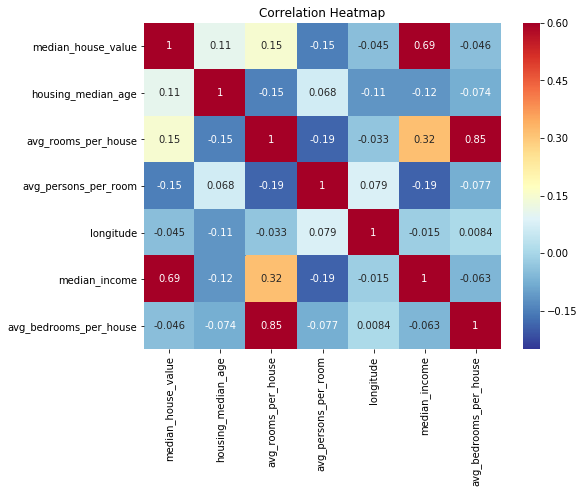

In [15]:
add_more_features(df)
ext_data = df[['median_house_value', 'housing_median_age','avg_rooms_per_house', 'avg_persons_per_room',
               'longitude','median_income', 'avg_bedrooms_per_house']]
ext_data_corrs = ext_data.corr()
ext_data_corrs


plt.figure(figsize = (8, 6))
# 繪製相關係數 (correlations) 的 Heatmap
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

In [16]:
# Define your feature columns
def create_feature_cols():
  return [
    tf.feature_column.numeric_column('housing_median_age'),
    tf.feature_column.bucketized_column(tf.feature_column.numeric_column('latitude'), boundaries = np.arange(32.0, 42, 1).tolist()),
    tf.feature_column.numeric_column('avg_rooms_per_house'),
    tf.feature_column.numeric_column('avg_persons_per_room'),
    tf.feature_column.numeric_column('avg_bedrooms_per_house'),  
    tf.feature_column.numeric_column('median_income')
      
  ]

In [17]:
# Create estimator train and evaluate function
def train_and_evaluate(output_dir, num_train_steps):
  estimator = tf.estimator.LinearRegressor(model_dir = output_dir, feature_columns = create_feature_cols())
  train_spec = tf.estimator.TrainSpec(input_fn = make_input_fn(traindf, None), 
                                      max_steps = num_train_steps)
  eval_spec = tf.estimator.EvalSpec(input_fn = make_input_fn(evaldf, 1), 
                                    steps = None, 
                                    start_delay_secs = 1, # start evaluating after N seconds, 
                                    throttle_secs = 5)  # evaluate every N seconds
  tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

In [18]:
# Launch tensorboard
OUTDIR = './trained_model'

In [19]:
# Run the model
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time
tf.summary.FileWriterCache.clear() # ensure filewriter cache is clear for TensorBoard events file
train_and_evaluate(OUTDIR, 2000)

I0901 12:44:27.129778 139811191924480 estimator.py:1790] Using default config.
I0901 12:44:27.131999 139811191924480 estimator.py:209] Using config: {'_keep_checkpoint_max': 5, '_num_worker_replicas': 1, '_task_type': 'worker', '_service': None, '_model_dir': './trained_model', '_global_id_in_cluster': 0, '_device_fn': None, '_is_chief': True, '_experimental_distribute': None, '_keep_checkpoint_every_n_hours': 10000, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f27eaa9f080>, '_eval_distribute': None, '_train_distribute': None, '_log_step_count_steps': 100, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_save_summary_steps': 100, '_experimental_max_worker_delay_secs': None, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_evaluation_master': '', '_master': '', '_tf_random_seed': None, '_num_ps_replicas': 0, '_protocol': None, '_task_id': 0}
/usr/local/lib/p

In [20]:
!git remote add origin https://github.com/tokpmpm/mlpratice.git

fatal: remote origin already exists.


In [ ]:
!git push -u origin master

Username for 'https://github.com': 